# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [3]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [4]:
bbc.sample(5)

,category,text
1627,politics,blair s hope for blunkett return the events le...
1862,sport,johnson uncertain about euro bid jade johnson ...
1187,sport,newcastle to join morientes race newcastle hav...
59,business,us regulator to rule on pain drug us food and ...
919,politics,eu referendum could cost £80m it could cost £...


In [5]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


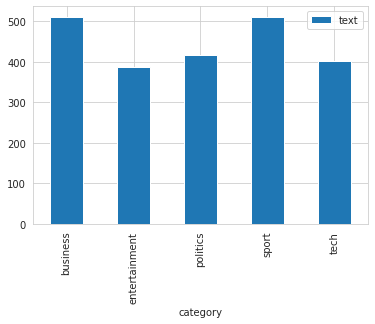

In [25]:
# Your code here
bbc.groupby('category').count().plot(kind='bar')

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(bbc['text']).toarray()
labels = bbc['category']

In [31]:
category2id = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}
id2category = {'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

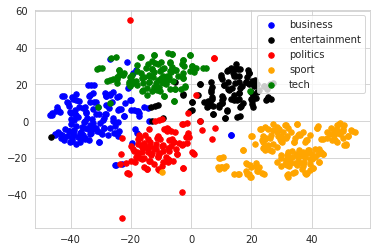

In [54]:
colors = ['blue', 'green', 'red', 'orange', 'black']
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)    
features_ = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) 

for category, id in sorted(id2category.items()):
    points = features_[(labels[indices] == category).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[id], label=category)
plt.legend()

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0),
]

In [57]:
cv_df = pd.DataFrame(index=range(5 * len(models)))
result = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
  for fold_idx, accuracy in enumerate(accuracies):
    result.append((model_name, fold_idx, accuracy))

In [58]:
result

[('RandomForestClassifier', 0, 0.7887640449438202),
 ('RandomForestClassifier', 1, 0.8),
 ('RandomForestClassifier', 2, 0.8359550561797753),
 ('RandomForestClassifier', 3, 0.8157303370786517),
 ('RandomForestClassifier', 4, 0.8202247191011236),
 ('LogisticRegression', 0, 0.9775280898876404),
 ('LogisticRegression', 1, 0.9842696629213483),
 ('LogisticRegression', 2, 0.9865168539325843),
 ('LogisticRegression', 3, 0.9752808988764045),
 ('LogisticRegression', 4, 0.9887640449438202)]

In [59]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=96)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=96)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, y_pred)

0.9865269461077845

Text(0.5, 15.0, 'Predicted')

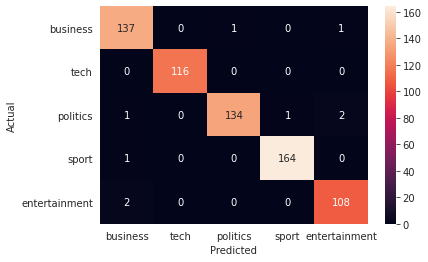

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category2id.values(), yticklabels=category2id.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')